In [1]:
import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib as mpl

import sklearn
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, confusion_matrix,precision_score, classification_report
import sklearn.linear_model as skl_lm

from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

In [2]:
df=pd.read_csv('./data/churn.csv').drop(columns=['RowNumber','Surname', 'CustomerId','Geography'], axis=1)
df.head(3)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,Female,42,8,159660.80,3,1,0,113931.57,1


In [3]:
df.columns

Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [4]:
df.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [5]:
df['Gender']=df['Gender'].apply(lambda x: 0 if x=='Female' else 1)

### I am  interested in predicting whether an individual will leave the bank whos client he is, on the basis of   CreditScore, Balance, number of products, Estimated Salary, Tenure

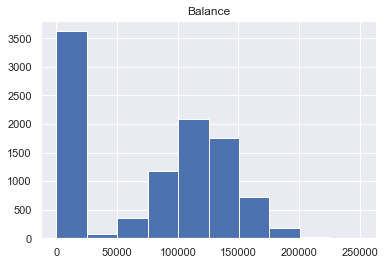

In [6]:
df.hist('Balance');

In [7]:
df['Exited'].value_counts() / len(df) *100

0    79.63
1    20.37
Name: Exited, dtype: float64

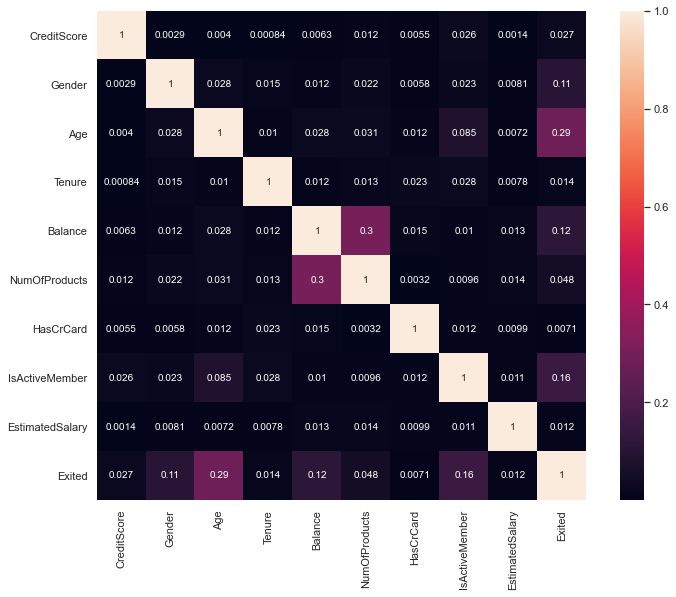

In [45]:
# Correlation matrix
corr_matrix = df.corr().abs()
fig, ax     = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix, vmax=1, square=True, annot=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0);
plt.savefig('CorrMatrix')

In [10]:
sns.pairplot(df, hue="Exited");

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Gender           10000 non-null  int64  
 2   Age              10000 non-null  int64  
 3   Tenure           10000 non-null  int64  
 4   Balance          10000 non-null  float64
 5   NumOfProducts    10000 non-null  int64  
 6   HasCrCard        10000 non-null  int64  
 7   IsActiveMember   10000 non-null  int64  
 8   EstimatedSalary  10000 non-null  float64
 9   Exited           10000 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 781.4 KB


### In this part, we  build a model to predict customer leave from the bank (Y ) for any given value of Creditscore (X1), Age (X2), number of product(X3), etc. Since Y is not quantitative, the simple linear regression is not appropriate.

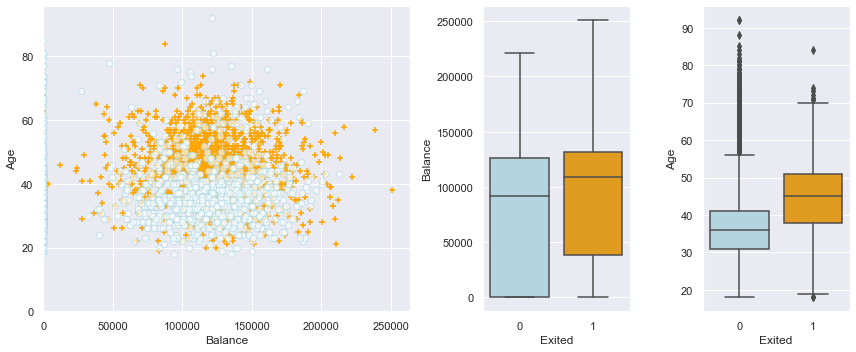

In [12]:
fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (customer_leave) is 'no'
df_no = df[df.Exited == 0].sample(frac=0.20)
# Take all samples  where target value is 'yes'
df_yes = df[df.Exited == 1]
df_ = df_no.append(df_yes)

ax1.scatter(df_[df_.Exited == 1].Balance, df_[df_.Exited == 1].Age, s=40, c='orange', marker='+',
            linewidths=1)
ax1.scatter(df_[df_.Exited == 0].Balance, df_[df_.Exited == 0].Age, s=40, marker='o', linewidths='1',
            edgecolors='lightblue', facecolors='white', alpha=.6)
ax1.set_ylim(ymin=0)
ax1.set_ylabel('Age')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

c_palette = {0:'lightblue', 1:'orange'}
sns.boxplot('Exited','Balance', data=df, orient='v', ax=ax2, palette=c_palette)
sns.boxplot('Exited', 'Age', data=df, orient='v', ax=ax3, palette=c_palette)

gs.tight_layout(plt.gcf())
plt.savefig('Age & Balance|Exited')

### Left: The Age and Balance of the existing customers. The individuals who left bank  are shown in orange, and those who did not are shown in blue. Center: Boxplots of Balance  as a function of leave status. Right: Boxplots of Age  as a function of leave status.


In [13]:
exit = pd.crosstab(df['Exited'], df['NumOfProducts'], rownames=['Exited'])
exit

NumOfProducts,1,2,3,4
Exited,,,,
0,3675,4242,46,0
1,1409,348,220,60


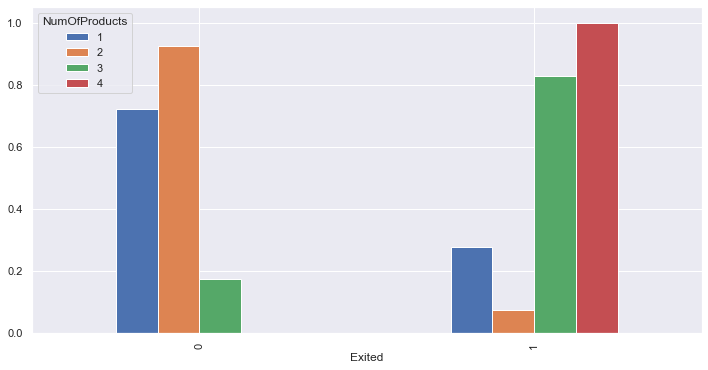

In [14]:
(exit / exit.apply(sum)).plot(kind="bar", figsize=(12, 6));
plt.savefig('Exited|NumOfProduct')

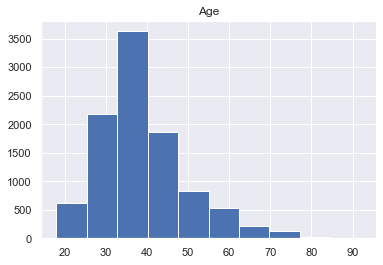

In [15]:
df.hist('Age');
plt.savefig('age')

In [128]:
exit = pd.crosstab(df['Exited'], [df['Balance']<1000], rownames=['Exited'])
exit

Balance,False,True
Exited,,
0,4846,3117
1,1537,500


### I can conlude that customers in average 45years old who had  4  products  100% left the Bank, however 68.3% amongst them having credit card.

###  Multiple Logistic Regression

In [47]:
df.describe()


,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,0.545700,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,0.497932,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,1.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,1.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [140]:
zero= df[(df['Balance']>10000) & (df['Exited']==1)& (df['Tenure']>3)]
len(zero)

986

In [42]:
zero=df.groupby(df['Exited']).agg({'Age': ['mean', 'min', 'max'], 'Balance':['mean','min','max'],
                                  'CreditScore':['mean','min','max'],
                                   'EstimatedSalary':['mean','min','max'],
                                   'NumOfProducts':['mean','min','max']})
zero

Age               Balance                 CreditScore            \
             mean min max          mean  min        max        mean  min  max   
Exited                                                                          
0       37.408389  18  92  72745.296779  0.0  221532.80  651.853196  405  850   
1       44.837997  18  84  91108.539337  0.0  250898.09  645.351497  350  850   

       EstimatedSalary                   NumOfProducts          
                  mean    min        max          mean min max  
Exited                                                          
0         99738.391772  90.07  199992.48      1.544267   1   3  
1        101465.677531  11.58  199808.10      1.475209   1   4

In [25]:
df.IsActiveMember.value_counts()

1    5151
0    4849
Name: IsActiveMember, dtype: int64

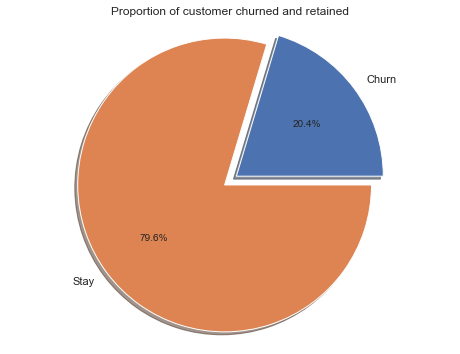

<Figure size 432x288 with 0 Axes>

In [90]:
labels = 'Churn', "Stay"
sizes = [df.Exited[df['Exited'] == 1].count(), df.Exited[df['Exited'] == 0].count()]
explode = (0.1, 0)

fig1, ax1 = plt.subplots(figsize=(8, 6))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')

plt.title("Proportion of customer churned and retained")

plt.show()
plt.savefig('pie_chart');